In [4]:
# Import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import cv2

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
import sklearn.metrics as metrics

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint

In [6]:
train = pd.read_csv("../../data/emnist/archive/emnist-balanced-train.csv")
test = pd.read_csv("../../data/emnist/archive/emnist-balanced-test.csv")
print(train.shape,test.shape)
mapp = pd.read_csv("../../data/emnist/archive/emnist-balanced-mapping.txt", delimiter = ' ', \
                   index_col=0, header=None, squeeze=True)
print("Train: %s, Test: %s, Map: %s" %(train.shape, test.shape, mapp.shape))

(112799, 785) (18799, 785)
Train: (112799, 785), Test: (18799, 785), Map: (47,)


/tmp/ipykernel_4724/1542083793.py:4: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  mapp = pd.read_csv("../../data/emnist/archive/emnist-balanced-mapping.txt", delimiter = ' ', \


In [7]:
train.head(10)

,45,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.524,0.525,0.526,0.527,0.528,0.529,0.530,0.531,0.532,0.533
0,36,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,20,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,46,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Constants
HEIGHT = 28
WIDTH = 28

In [9]:
# Split x and y
# выбираем все столбцы начиная с 1-го
train_x = train.iloc[:,1:]
# выбираем нулевой столбец
train_y = train.iloc[:,0]
del train

test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]
del test

In [10]:
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(112799, 784) (112799,) (18799, 784) (18799,)


In [11]:
def rotate(image):
    image = image.reshape([HEIGHT, WIDTH])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

In [12]:
# Flip and rotate image
train_x = np.asarray(train_x)
# Для каждого элемента в массиве применяем функцию
train_x = np.apply_along_axis(rotate, 1, train_x)
print ("train_x:",train_x.shape)

test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate, 1, test_x)
print ("test_x:",test_x.shape)

train_x: (112799, 28, 28)
test_x: (18799, 28, 28)


In [13]:
# Normalise
train_x = train_x.astype('float32')
train_x /= 255
test_x = test_x.astype('float32')
test_x /= 255


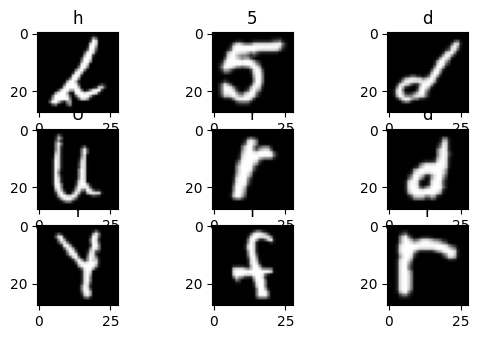

In [14]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(train_x[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(mapp[train_y[i]]))

In [15]:
# number of classes
num_classes = train_y.nunique()

In [16]:
print(num_classes)

47


this is to one hot encoding - so if char is a : then for a it will be a->1 and others 0.  E.g. for use with categorical_crossentropy

In [17]:
# One hot encoding
train_y = np_utils.to_categorical(train_y, num_classes)
test_y = np_utils.to_categorical(test_y, num_classes)
print("train_y: ", train_y.shape)
print("test_y: ", test_y.shape)

train_y:  (112799, 47)
test_y:  (18799, 47)


In [18]:
# Reshape image for CNN
train_x = train_x.reshape(-1, HEIGHT, WIDTH, 1)
test_x = test_x.reshape(-1, HEIGHT, WIDTH, 1)

In [19]:
print("train: ",train_x.shape,"test: ",test_x.shape )

train:  (112799, 28, 28, 1) test:  (18799, 28, 28, 1)


In [20]:
# partition to train and val
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.20, random_state=7)

In [21]:
# Building model
# ((Si - Fi + 2P)/S) + 1
model = Sequential()
## сверточный слой
#               число каналов | размер ядра | подгоняет выходную карту признаков под исходное изображение | функция активации |
model.add(Conv2D(filters=128, kernel_size=(5,5), padding = 'same', activation='relu',\
                 input_shape=(HEIGHT, WIDTH,1)))
#                                      | шаг сканирования фильтров

# MaxPooling2D укрупняет масштаб полученных признаков
#               размер окна в котором выбирается максимальное значение | шаг сканирования по координатам плоскости
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

# сверточный слой, который использует предыдущие карты признаков
model.add(Conv2D(filters=64, kernel_size=(3,3) , padding = 'same', activation='relu'))
# уменьшаем карту признаков в 2 раза
# pooling - изменение масштаба
model.add(MaxPooling2D(pool_size=(2,2)))

# на выходе имеем тензор ?*?*64 (? | ? | каналы)

# "вытягиваем" тензор в вектор для подачи на полносвязную нейронную сеть
model.add(Flatten())
# полносвязный слой
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(.5))
# полносвязный слой, который дает конечный результат
model.add(Dense(units=num_classes, activation='softmax'))

model.summary()

2022-12-02 21:09:04.189863: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ivan/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-12-02 21:09:04.190138: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-02 21:09:04.190180: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ivan-Lenovo): /proc/driver/nvidia/version does not exist
2022-12-02 21:09:04.191157: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [22]:
# определяем необходимые параметры модели (функцию потери, оптимизатор, метрики(accuracy - % правильно распознанных)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [23]:
MCP = ModelCheckpoint('../models/Best_points.h5',verbose=1,save_best_only=True,monitor='val_accuracy',mode='max')
ES = EarlyStopping(monitor='val_accuracy',min_delta=0,verbose=0,patience=3,mode='max')
RLP = ReduceLROnPlateau(monitor='val_loss',patience=3,factor=0.2,min_lr=0.0001)

In [24]:
history = model.fit(train_x, train_y, epochs=50, batch_size=512, verbose=1, \
                    validation_data=(val_x, val_y),callbacks=[MCP,ES,RLP])

Epoch 1/50
177/177 [==============================] - ETA: 0s - loss: 1.7711 - accuracy: 0.5041
Epoch 1: val_accuracy improved from -inf to 0.79973, saving model to Best_points.h5
177/177 [==============================] - 80s 446ms/step - loss: 1.7711 - accuracy: 0.5041 - val_loss: 0.6218 - val_accuracy: 0.7997 - lr: 0.0010
Epoch 2/50
177/177 [==============================] - ETA: 0s - loss: 0.8471 - accuracy: 0.7355
Epoch 2: val_accuracy improved from 0.79973 to 0.83808, saving model to Best_points.h5
177/177 [==============================] - 72s 404ms/step - loss: 0.8471 - accuracy: 0.7355 - val_loss: 0.4831 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 3/50
177/177 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.7779
Epoch 3: val_accuracy improved from 0.83808 to 0.84987, saving model to Best_points.h5
177/177 [==============================] - 90s 507ms/step - loss: 0.6875 - accuracy: 0.7779 - val_loss: 0.4368 - val_accuracy: 0.8499 - lr: 0.0010
Epoch 4/50
17

In [25]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc,title):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

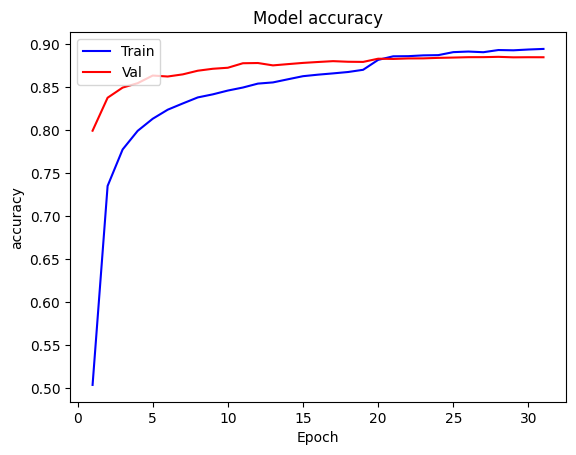

In [28]:
# Accuracy curve
plotgraph(epochs, acc, val_acc,"accuracy")

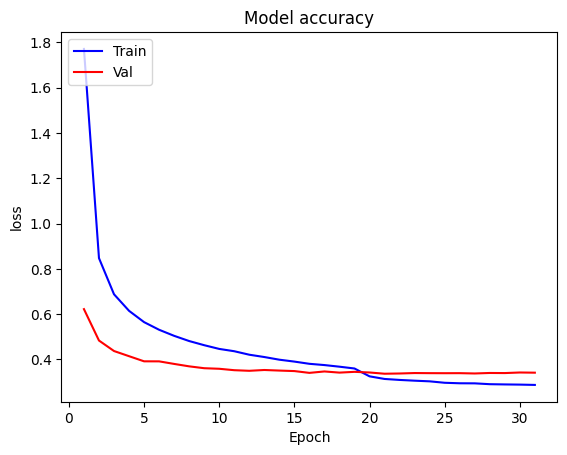

In [29]:
# loss curve
plotgraph(epochs, loss, val_loss,"loss")

In [30]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.35821977257728577
Test accuracy: 0.883344829082489
